# Visualization of Temperatures

In [1]:
import pandas as pd
import datetime as dt
import pymongo
import dns
import matplotlib.pyplot as plt
import seaborn as sns
import panel as pn
import numpy as np
import matplotlib.pyplot as pl
import pymongo
import geopandas as gpd
import panel.widgets as pnw
import json
from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.plotting import figure
from bokeh.palettes import brewer
from math import sin, cos, atan2, sqrt, pi
from shapely.geometry import Point, LineString, shape
pn.extension()

In [2]:
#Connection to MongoDb
def mongo_connect():
    try:
        username = "Freddoloso"
        password = "Milano01"
        url = "mongodb+srv://%s:%s@cluster0.gg85x.mongodb.net/<dbname>?retryWrites=true&w=majority"
        client = pymongo.MongoClient(url % (username, password))
        if (client is not None):
            status_conn = client.db_name.command('ping')
    except Exception as e:
        print(e)
        client = None
        status_conn = None
    return client 

In [3]:
#Select data Countries by year
def sel_country_by_year (year=None):
    
    client = mongo_connect()
    
    if(client is not None):
        db = client["Map_temperatures"]
        col = db["by_country"]

        df = pd.DataFrame(
             col.aggregate([
                {"$match":{"year": year}},
                {"$group":
                    {
                        "_id": {"Country": "$Country", 
                                "Country_code": "$Country_code"} ,
                        "AverageTemperatureCountry" : {"$avg": "$AverageTemperature"}
                    }
                },
                {"$project": {
                  "_id": 0,
                  "Country": "$_id.Country",
                  "Country_code": "$_id.Country_code",
                  "AverageTemp": "$AverageTemperatureCountry",
                  "count": 1,
                  "sum": 1
               }}
        ])) 
    return df

In [4]:
#Read shapefile using Geopandas
#Drop row corresponding to 'Antarctica'(it's a big area in in which we have no data)
def get_shape_file():
    shapefile = 'data\\world_map\\ne_110m_admin_0_countries.shp'  
    gpd_shapefile = gpd.read_file(shapefile)
    gpd_shapefile = gpd_shapefile.drop(gpd_shapefile.index[159])
    return gpd_shapefile

In [5]:
#Merge DataFrame and Shape File
def merge_shape_file (year=None):
    """Merge Shape File with DataFrame of Countries"""
    df_country=sel_country_by_year(year)
  
    #Read shapefile using Geopandas
    gpd_shapefile = get_shape_file()[['ADMIN', 'ADM0_A3', 'geometry']]
    
    #Rename columns 
    gpd_shapefile.columns = ['country', 'country_code', 'geometry']
    
    #Drop row corresponding to 'Antarctica'(it's a big area in in which we have no data)
    gpd_shapefile = gpd_shapefile.drop(gpd_shapefile.index[159])

    #Merge by country code
    gpd_merged = gpd_shapefile.merge(df_country, left_on='country_code', right_on='Country_code', how='left')
    key = df_country.columns[2]  

    return gpd_merged, key

In [6]:
#Plot map
def plot_map(gdf, key=None, title=''):

    geosource = GeoJSONDataSource(geojson=gdf.to_json())
    palette = ('#4575b4',
               '#74add1',
               '#abd9e9',
               '#e0f3f8',
               '#ffffa0',
               '#ffC000',
               '#ff6000',
               '#c51d34')
    
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = -40, high = 40, nan_color = '#d9d9d9')
    
    #Define custom labels for color bar
    colorbar_labels = {'0': '0°', '10':'10°', '20':'20°', '30':'30°', '40': '40°', '-10':'-10°', '-20':'-20°', '-30':'-30°', '-40': '-40°'}
    
    #Create ColorBar
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20,
                         location=(0,0), orientation='horizontal', major_label_overrides = colorbar_labels)

    #Add hover tool
    hover = HoverTool(tooltips=[('Country/region','@country'),('AverageTemp', '@AverageTemp')])
    
    p = figure(title=title, plot_height=400 , plot_width=850, toolbar_location='right', tools=[hover])
    p.xgrid.grid_line_color = None  #per cancellare la griglia sopra la mappa
    p.ygrid.grid_line_color = None
    
    #Add patch renderer to figure: every patch is a nation. Geometries and positions of each patch are in the geodatasource. 
    #Fill color is necessary to color values in the column, using the colormapper.
    p.patches('xs','ys', source=geosource, fill_alpha=1, line_width=0.5, line_color='black',  
              fill_color={'field' :key , 'transform': color_mapper})
    
    #Specify figure layout.
    p.add_layout(color_bar, 'below')
    return p


In [7]:
#Create the Bokeh interactive map 
def show_map():
    map_pane = pn.pane.Bokeh(width=800)
    year_slider = pnw.IntSlider(start=1750,end=2013,value=1900)
    
    def update_map(event):
        gdf,key = merge_shape_file (year=year_slider.value)        
        map_pane.object = plot_map(gdf, key, title='Average temperature in a specific year')
       
    year_slider.param.watch(update_map,'value_throttled')  
    year_slider.param.trigger('value_throttled')
    app = pn.Column(map_pane, year_slider)
    return app

In [8]:
#Show the map
map = show_map()
map

Column
    [0] Bokeh(Figure, width=800)
    [1] IntSlider(end=2013, start=1750, value=1900, value_throttled=1900)

# Analysis of the largest deviations

In [9]:
#Select data Cities 
def sel_cities (year=1900):
    
    client = mongo_connect()
    if(client is not None):
        db = client["Map_temperatures"]
        col = db["by_major_city"]

        df = pd.DataFrame(
            col.aggregate([
                {"$match": {"year": {"$gte": year}}},
                {"$group":
                    {
                        "_id": {"City": "$City",
                                "dt": "$dt",
                                "year" : {"$year" :  "$dt"},
                                "month" : {"$month" :  "$dt"},
                                "day" : {"$dayOfMonth" :  "$dt"},
                                "Latitude": "$Latitude", "Longitude": "$Longitude"},
                                "AverageTemperatureCity": {"$avg":"$AverageTemperature"}, 
                                "AverageTemperatureUncertainty": {"$avg":"$AverageTemperatureUncertainty"}
                    }
                },
                {"$project": {
                    "_id": 0,
                    "City": "$_id.City",
                    "date" : "$_id.dt",
                    "year" : "$_id.year",
                    "month" : "$_id.month",
                    "day": "$_id.day",
                    "Latitude": "$_id.Latitude",
                    "Longitude": "$_id.Longitude",
                    "AverageTemp": "$AverageTemperatureCity",
                    "AvgTempUncertanty": "$AverageTemperatureUncertainty",
                    "count": 1,
                    "sum": 1
                }}
            ]))

    return df

In [10]:
df_city=sel_cities()
df_city.head()

,City,date,year,month,day,Latitude,Longitude,AverageTemp,AvgTempUncertanty
0,Tokyo,1984-05-01,1984,5,1,36.17,139.23,15.405,0.105
1,Seoul,1980-10-01,1980,10,1,37.78,126.10,12.174,0.144
2,Cairo,1997-11-01,1997,11,1,29.74,31.38,19.473,0.154
3,Luanda,2011-10-01,2011,10,1,-8.84,13.78,23.348,1.177
4,Singapore,1919-02-01,1919,2,1,0.80,103.66,26.567,0.572


In [11]:
#Convert "date" to date files and select it as index.
df_city["date"] = pd.to_datetime(df_city[['year', 'month', 'day']])
df_city.set_index("date", inplace=True)
df_city.drop(['year', 'month', 'day'], axis=1, inplace=True)
df_city

,City,Latitude,Longitude,AverageTemp,AvgTempUncertanty
date,,,,,
1984-05-01,Tokyo,36.17,139.23,15.405,0.105
1980-10-01,Seoul,37.78,126.10,12.174,0.144
1997-11-01,Cairo,29.74,31.38,19.473,0.154
2011-10-01,Luanda,-8.84,13.78,23.348,1.177
1919-02-01,Singapore,0.80,103.66,26.567,0.572
...,...,...,...,...,...
1931-02-01,Nagpur,21.70,78.75,22.735,1.298
1982-04-01,Chongqing,29.74,107.08,15.121,0.209
2007-05-01,Taipei,24.92,122.36,24.790,0.378


In [12]:
#Define the annual frequence of index
df_city = df_city.to_period(freq='A')
df_city

,City,Latitude,Longitude,AverageTemp,AvgTempUncertanty
date,,,,,
1984,Tokyo,36.17,139.23,15.405,0.105
1980,Seoul,37.78,126.10,12.174,0.144
1997,Cairo,29.74,31.38,19.473,0.154
2011,Luanda,-8.84,13.78,23.348,1.177
1919,Singapore,0.80,103.66,26.567,0.572
...,...,...,...,...,...
1931,Nagpur,21.70,78.75,22.735,1.298
1982,Chongqing,29.74,107.08,15.121,0.209
2007,Taipei,24.92,122.36,24.790,0.378


In [13]:
#Calculate the global temperature
global_temp_annual = df_city.resample('A').agg(['mean', 'min', 'max'])
global_temp_annual[global_temp_annual.columns[-6:]]

AverageTemp                AvgTempUncertanty              
            mean    min     max              mean    min    max
date                                                           
1900   19.422391 -7.073  35.487          0.847318  0.214  3.954
1901   19.284870 -6.957  35.863          0.828551  0.186  3.831
1902   19.295213 -6.748  36.115          0.787005  0.090  3.401
1903   18.975424 -6.718  36.052          0.777545  0.150  4.756
1904   18.880659 -7.085  35.156          0.722752  0.128  4.196
...          ...    ...     ...               ...    ...    ...
2009   20.227376 -6.917  36.607          0.352701  0.071  1.532
2010   20.419321 -6.906  37.899          0.363830  0.072  1.941
2011   20.002260 -7.057  37.184          0.388852  0.079  3.963
2012   20.149948 -6.562  37.859          0.497301  0.113  3.782
2013   20.745292 -6.914  37.126          0.580389  0.124  3.621

[114 rows x 6 columns]

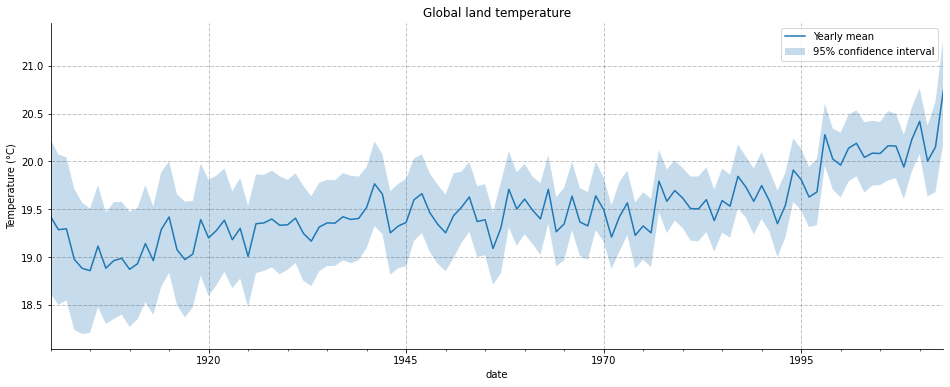

In [14]:
#Plotting global temperatures with temperature uncertainty from 1900 to 2013.
global_temp_annual[('AverageTemp', 'mean')].plot(figsize=(16, 6), label='Yearly mean')
ax = plt.gca()
ax.fill_between(global_temp_annual.index, global_temp_annual[('AverageTemp', 'mean')] - 0.95*global_temp_annual[('AvgTempUncertanty', 'mean')], 
                            global_temp_annual[('AverageTemp', 'mean')] +  0.95*global_temp_annual[('AvgTempUncertanty', 'mean')], alpha=.25, label='95% confidence interval')
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.25)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Temperature (°C)")
plt.title('Global land temperature')
plt.legend()
sns.despine()

In [15]:
#Define average temperatures for every cities over time.
df_city = df_city.groupby(['date','City', 'Latitude','Longitude']).agg(annual_temp_city=('AverageTemp', 'mean'), annual_temp_unc_city=('AvgTempUncertanty', 'mean'))
df_city = df_city.reset_index()
df_city.set_index("date", inplace=True)
df_city

,City,Latitude,Longitude,annual_temp_city,annual_temp_unc_city
date,,,,,
1900,Abidjan,5.63,-3.23,26.118500,0.868917
1900,Addis Abeba,8.84,38.11,17.311417,1.229667
1900,Ahmadabad,23.31,72.52,26.902667,0.564833
1900,Aleppo,36.17,37.79,17.582917,0.632333
1900,Alexandria,31.35,30.16,20.726833,0.643500
...,...,...,...,...,...
2013,Tokyo,36.17,139.23,13.911500,0.526125
2013,Toronto,44.20,-80.50,8.459444,0.436778
2013,Umm Durman,15.27,32.50,30.650500,0.693625


In [28]:
#Define start and end period of analysis
start_period = df_city.index > '1900'
end_period = df_city.index <= '2013'

#Create dataframe with data for the selected period
df_city_period = df_city[np.logical_and.reduce([start_period, end_period])]
df_city_period

,City,Latitude,Longitude,annual_temp_city,annual_temp_unc_city
date,,,,,
1901,Abidjan,5.63,-3.23,25.918250,0.855167
1901,Addis Abeba,8.84,38.11,17.611250,1.457250
1901,Ahmadabad,23.31,72.52,26.831500,0.476917
1901,Aleppo,36.17,37.79,18.370250,0.826917
1901,Alexandria,31.35,30.16,20.885250,0.559500
...,...,...,...,...,...
2013,Tokyo,36.17,139.23,13.911500,0.526125
2013,Toronto,44.20,-80.50,8.459444,0.436778
2013,Umm Durman,15.27,32.50,30.650500,0.693625


In [29]:
#Calculate the average values in the selected period
df_city_avg_period = df_city_period.groupby(['City', 'Latitude','Longitude']).agg(avg_temp_period_bycity=('annual_temp_city', 'mean'), avg_temp_period_unc_bycity=('annual_temp_unc_city', 'mean'))
df_city_avg_period

,,,avg_temp_period_bycity,avg_temp_period_unc_bycity
City,Latitude,Longitude,,
Abidjan,5.63,-3.23,26.364045,0.509412
Addis Abeba,8.84,38.11,17.622771,0.725348
Ahmadabad,23.31,72.52,26.793000,0.454076
Aleppo,36.17,37.79,17.702716,0.444153
Alexandria,31.35,30.16,20.609126,0.375142
...,...,...,...,...
Tokyo,36.17,139.23,12.744204,0.263932
Toronto,44.20,-80.50,8.103134,0.278478
Umm Durman,15.27,32.50,29.220892,0.664497


In [30]:
#Union of the two dataframes to have only 1 dataframe with annual specifical temperatures for each city and the average temperature of the period considered for each city
df_city_period = df_city_period.reset_index()
df_city_period=pd.merge(left =df_city_period, right=df_city_avg_period, left_on = 'City', right_on = 'City', how = 'left')
df_city_period.set_index("date", inplace=True)

In [31]:
#Calculate the annual temperature anomaly (in abs value) in comparison to the average temperature in the period selected
#Sort the results 
df_city_period['temp_anomaly'] = (df_city_period['annual_temp_city']-df_city_period['avg_temp_period_bycity']).abs()
df_city_period = df_city_period.sort_values(by='temp_anomaly', ascending=False)
df_city_period

,City,Latitude,Longitude,annual_temp_city,annual_temp_unc_city,avg_temp_period_bycity,avg_temp_period_unc_bycity,temp_anomaly
date,,,,,,,,
2013,Moscow,55.45,36.85,11.853000,0.379833,7.496720,0.337604,4.356280
1919,Moscow,55.45,36.85,11.576429,0.470571,7.496720,0.337604,4.079709
2010,Moscow,55.45,36.85,11.520667,0.233778,7.496720,0.337604,4.023947
2013,Shenyang,40.99,123.55,15.817500,0.656167,11.856026,0.386922,3.961474
1947,Harbin,45.81,125.77,15.336143,0.414571,11.825772,0.388892,3.510371
...,...,...,...,...,...,...,...,...
1948,Lakhnau,26.52,80.60,25.016500,0.375750,25.016678,0.456338,0.000178
1948,Kanpur,26.52,80.60,25.016500,0.375750,25.016678,0.456338,0.000178
1977,Lahore,31.35,73.51,24.322500,0.374750,24.322387,0.406539,0.000113


In [32]:
#Focus on a particular city to verify its temperature anomalies over time
df_city_period_onecity= df_city_period.loc[(df_city_period['City'] == 'Moscow')]
df_city_period_onecity = df_city_period_onecity.sort_values(by='date')
df_city_period_onecity

,City,Latitude,Longitude,annual_temp_city,annual_temp_unc_city,avg_temp_period_bycity,avg_temp_period_unc_bycity,temp_anomaly
date,,,,,,,,
1901,Moscow,55.45,36.85,8.845889,0.576222,7.49672,0.337604,1.349169
1902,Moscow,55.45,36.85,6.619778,0.593333,7.49672,0.337604,0.876942
1903,Moscow,55.45,36.85,7.847800,0.517900,7.49672,0.337604,0.351080
1904,Moscow,55.45,36.85,5.506600,0.535100,7.49672,0.337604,1.990120
1905,Moscow,55.45,36.85,6.046273,0.461000,7.49672,0.337604,1.450447
...,...,...,...,...,...,...,...,...
2009,Moscow,55.45,36.85,6.850091,0.257364,7.49672,0.337604,0.646629
2010,Moscow,55.45,36.85,11.520667,0.233778,7.49672,0.337604,4.023947
2011,Moscow,55.45,36.85,9.234900,0.261800,7.49672,0.337604,1.738180


Text(0.5, 1.0, 'Annual temperature of Mashhad in period selected')

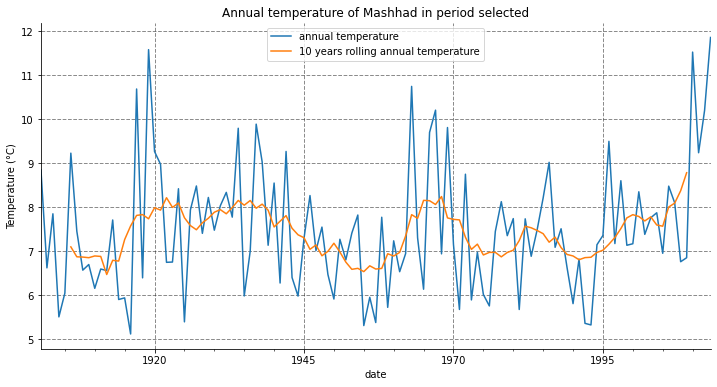

In [33]:
#Plotting annual temperature of the selected city
df_city_period_onecity['annual_temp_city'].plot(label='annual temperature', figsize=(12, 6))
df_city_period_onecity['annual_temp_city'].rolling(10, center=True).mean().plot(label='10 years rolling annual temperature')
ax = plt.gca()
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.ylabel("Temperature (°C)")
sns.despine()
plt.title('Annual temperature of Moscow in period selected')

In [22]:
#Reset index of the df_city_period DataFrame of the selected period.
df_city_period.reset_index(level=0, inplace=True)
df_city_period

,date,City,Latitude,Longitude,annual_temp_city,annual_temp_unc_city,avg_temp_period_bycity,avg_temp_period_unc_bycity,temp_anomaly
0,2013,Moscow,55.45,36.85,11.853000,0.379833,7.496720,0.337604,4.356280
1,1919,Moscow,55.45,36.85,11.576429,0.470571,7.496720,0.337604,4.079709
2,2010,Moscow,55.45,36.85,11.520667,0.233778,7.496720,0.337604,4.023947
3,2013,Shenyang,40.99,123.55,15.817500,0.656167,11.856026,0.386922,3.961474
4,1947,Harbin,45.81,125.77,15.336143,0.414571,11.825772,0.388892,3.510371
...,...,...,...,...,...,...,...,...,...
11295,1948,Lakhnau,26.52,80.60,25.016500,0.375750,25.016678,0.456338,0.000178
11296,1948,Kanpur,26.52,80.60,25.016500,0.375750,25.016678,0.456338,0.000178
11297,1977,Lahore,31.35,73.51,24.322500,0.374750,24.322387,0.406539,0.000113
11298,1977,Faisalabad,31.35,73.51,24.322500,0.374750,24.322387,0.406539,0.000113


In [23]:
#Plots a white map
def plot_white_map(gdf, key=None, title=''):

    geosource = GeoJSONDataSource(geojson=gdf.to_json())
        
    p = figure(title=title, plot_height=400 , plot_width=850, toolbar_location='right' )
    
    #To delete grid lines in map
    p.xgrid.grid_line_color = None  
    p.ygrid.grid_line_color = None

    #Fill the countries (patch the countries) of white
    p.patches('xs','ys', source=geosource, fill_alpha=1, line_width=0.5, line_color='black', fill_color='white')    
    return p


In [24]:
#Create the Bokeh interactive map 
def show_map_anomaly():
    map_pane = pn.pane.Bokeh(width=800)
    year_slider = pnw.IntSlider(start=1900,end=2013,value=2013)

    gdf = get_shape_file()
    hover_tooltips = [("City", "@cities"),("Anomaly °","@temp_anomaly")]

    def update_map(event):
        map_obj = plot_white_map(gdf, title='Temp Anomaly')
        
        df_anomaly =df_city_period.loc[df_city_period['date']==str(year_slider.value)]
                                                 
        circle_source = ColumnDataSource(data=dict(
                    x=df_anomaly["Longitude"],
                    y=df_anomaly["Latitude"],
                    cities=df_anomaly["City"],
                    temp_anomaly=df_anomaly["temp_anomaly"]
                ))
        map_obj.circle('x', 'y', source=circle_source, radius='temp_anomaly', line_color ='#ff0000', fill_color ='w', name='circles') #join on names
        hover = HoverTool(tooltips=hover_tooltips, names=['circles'])                                                                 #join on names
        map_obj.add_tools(hover)
        map_pane.object = map_obj
           
    #When the year_slider.value changes recall update_map function
    year_slider.param.watch(update_map, 'value_throttled')  
    
    #To set a deafult value
    year_slider.param.trigger('value_throttled')
    
    app = pn.Column(year_slider, map_pane)
    
    return app

In [25]:
show_map_anomaly()

Traceback (most recent call last):
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\pandas\core\indexes\base.py", line 2898, in get_loc
 return self._engine.get_loc(casted_key)
 File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
 File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
 File "pandas\_libs\hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
 File "pandas\_libs\hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'date'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\pyviz_comms\__init__.py", line 316, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\panel\viewable.py", line 259, in _on_msg
 doc.unhold()
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\bokeh\document\document.py", line 668, in unhold
 self._trigger_on_change(event)
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\bokeh\document\document.py", line 1151, in _trigger_on_change
 self._with_self_as_curdoc(event.callback_invoker)
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\bokeh\document\document.py", line 1169, in _with_self_as_curdoc
 return f()
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\bokeh\util\callback_manager.py", line 155, in invoke
 callback(attr, old, new)
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\panel\reactive.py", line 216, in _comm_change
 self._process_events({attr: new})
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\panel\reactive.py", line 187, in _process_events
 self.param.set_param(**self._process_property_change(events))
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\param\parameterized.py", line 1451, in set_param
 self_._batch_call_watchers()
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\param\parameterized.py", line 1578, in _batch_call_watchers
 watcher.fn(*events)
 File "<ipython-input-24-2747370aa8e6>", line 12, in update_map
 df_anomaly =df_city_period.loc[df_city_period['date']==str(year_slider.value)]
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py", line 2906, in __getitem__
 indexer = self.columns.get_loc(key)
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\pandas\core\indexes\base.py", line 2900, in get_loc
 raise KeyError(key) from err
KeyError: 'date'
 


 Traceback (most recent call last):
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\pandas\core\indexes\base.py", line 2898, in get_loc
 return self._engine.get_loc(casted_key)
 File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
 File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
 File "pandas\_libs\hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
 File "pandas\_libs\hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'date'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\pyviz_comms\__init__.py", line 316, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\panel\viewable.py", line 259, in _on_msg
 doc.unhold()
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\bokeh\document\document.py", line 668, in unhold
 self._trigger_on_change(event)
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\bokeh\document\document.py", line 1151, in _trigger_on_change
 self._with_self_as_curdoc(event.callback_invoker)
 File "C:\Users\Matteo\anaconda3\envs\geo_env\lib\site-packages\bokeh\document\d

Column
    [0] IntSlider(end=2013, start=1900, value=2013, value_throttled=2013)
    [1] Bokeh(Figure, width=800)